In [1]:
# EDA
import pandas as pd
import numpy as np

# oracle sql
import cx_Oracle

## date handling
from datetime import datetime, timedelta
import pytz
from pytz import timezone

# visualizing
import seaborn as sns
import matplotlib.pyplot as plt

# modelling
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor

# accuracy metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# scaling
from sklearn.preprocessing import StandardScaler

# deployment
import pickle as pkl
from sklearn.pipeline import Pipeline

## for ignoring deprecation warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df=pd.read_parquet('df.parquet')
df=df.sort_values(['BANK_TIME'],ascending=True)

In [3]:
df.tail()

,BANK_TIME,TERMOWNER,CASHBACK_RATE,CASHBACK_AMOUNT,BALANCE_AFTER,DIRECTION,PIN,MARSTAT,BIRTH_DATE,HIREDATE,MCC,MCC_DESCRIPTION,MCC_GROUP,ID,CURRENCY,NAME
276923,2023-05-31 02:52:35,www.birbank.az,0.0,0.0,0.0,CREDIT,70JJ5LN,Subay,27.12.1999,08.12.2021,6012,Member Financial Institution-Merchandise,SERVICE PROVIDER,944,AZN,Азербайджанский манат
1768689,2023-05-31 02:56:15,www.birbank.az/mobil,1.0,0.0,1.8,CREDIT,5G4GHC0,Evli,23.07.1992,17.02.2015,4814,Telecommunication Serv.Includ. Local/L.D,UTILITY AND CABLE SERVICES,944,AZN,Азербайджанский манат
1835227,2023-05-31 03:33:51,www.birbank.az/creditpay,0.0,0.0,34.6,CREDIT,55FXY6L,Evli,11.12.1991,23.11.2015,6012,Member Financial Institution-Merchandise,SERVICE PROVIDER,944,AZN,Азербайджанский манат
1794771,2023-05-31 03:44:52,www.birbank.az/mobil,1.0,0.0,0.0,CREDIT,62CXFQA,Subay,19.11.1995,24.09.2019,4814,Telecommunication Serv.Includ. Local/L.D,UTILITY AND CABLE SERVICES,944,AZN,Азербайджанский манат
1032061,2023-05-31 03:52:51,www.birbank.az/mobil,1.0,0.1,21.5,CREDIT,8KZ2BVD,Subay,03.04.1999,07.07.2021,4814,Telecommunication Serv.Includ. Local/L.D,UTILITY AND CABLE SERVICES,944,AZN,Азербайджанский манат


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2067841 entries, 76696 to 1032061
Data columns (total 16 columns):
 #   Column           Dtype         
---  ------           -----         
 0   BANK_TIME        datetime64[ns]
 1   TERMOWNER        object        
 2   CASHBACK_RATE    float64       
 3   CASHBACK_AMOUNT  float64       
 4   BALANCE_AFTER    float64       
 5   DIRECTION        object        
 6   PIN              object        
 7   MARSTAT          object        
 8   BIRTH_DATE       object        
 9   HIREDATE         object        
 10  MCC              object        
 11  MCC_DESCRIPTION  object        
 12  MCC_GROUP        object        
 13  ID               int64         
 14  CURRENCY         object        
 15  NAME             object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(11)
memory usage: 268.2+ MB


In [5]:
df.describe()

,CASHBACK_RATE,CASHBACK_AMOUNT,BALANCE_AFTER,ID
count,2.067841e+06,2.067841e+06,2.067841e+06,2.067841e+06
mean,1.415615e+00,3.178639e-01,1.583896e+01,9.202852e+02
std,1.302489e+00,2.422149e+00,5.019633e+01,4.365295e+01
min,0.000000e+00,0.000000e+00,-9.939000e+02,8.400000e+02
25%,5.000000e-01,0.000000e+00,1.100000e+00,9.440000e+02
50%,1.500000e+00,1.000000e-01,3.600000e+00,9.440000e+02
75%,1.500000e+00,2.000000e-01,1.200000e+01,9.440000e+02
max,4.000000e+01,5.000000e+02,2.017500e+03,9.780000e+02


In [6]:
df.shape

(2067841, 16)

In [7]:
print(df.duplicated().sum())

610


In [8]:
print(df.isna().sum())

BANK_TIME              0
TERMOWNER            184
CASHBACK_RATE          0
CASHBACK_AMOUNT        0
BALANCE_AFTER          0
DIRECTION              0
PIN                    0
MARSTAT            10459
BIRTH_DATE          8599
HIREDATE               0
MCC                    0
MCC_DESCRIPTION        0
MCC_GROUP              0
ID                     0
CURRENCY               0
NAME                   0
dtype: int64


In [9]:
pins_with_missing_birth_date = df.loc[df['BIRTH_DATE'].isna(), 'PIN'].unique()
print(pins_with_missing_birth_date)


['2HMSQWC' '2G6YY4S' '64VD1S7' '79M3S2S' '2S01CBB' '7B0NXNB' '7BG1FM4'
 '1ACPJ8A' '5UF6ZCH' '6ASJEYW' '6FGY79G' '695RS9Z' '2NNJ13X' '35TAZN2'
 '69V61VM' '2VJQK1L' '62SZ34W' '69RDZ6Q' '66C5MCC' '53J096K' '6E3LSS1'
 '2EX05D2' '60CFME6' '61ACKXS' '41SL261' '63BH03P' '2S90MKA' '6AWFSBZ'
 '5EKJR6D' '67C0RMU' '136GML5' '33Q2NRJ' '1ALBH5B']


In [10]:
columns_to_fill = ['MARSTAT', 'TERMOWNER', 'BIRTH_DATE']

for column in columns_to_fill:
    mode_value = df[column].mode().iloc[0]
    df[column].fillna(mode_value, inplace=True)

In [11]:
print(df.isna().sum())

BANK_TIME          0
TERMOWNER          0
CASHBACK_RATE      0
CASHBACK_AMOUNT    0
BALANCE_AFTER      0
DIRECTION          0
PIN                0
MARSTAT            0
BIRTH_DATE         0
HIREDATE           0
MCC                0
MCC_DESCRIPTION    0
MCC_GROUP          0
ID                 0
CURRENCY           0
NAME               0
dtype: int64


In [12]:
pd.DataFrame(df['MCC_GROUP'].value_counts())

,MCC_GROUP
RETAIL STORES,653076
SERVICE PROVIDER,424212
VARIOUS SHOPS,322557
UTILITY AND CABLE SERVICES,268481
TRANSPORT,207732
AUTOMOBILES AND VEHICLES,76062
CLOTHING STORES,44591
BUSINESS SERVICES,15986
ENTERTAINMENT,13816
PROFESSIONAL SERVICES,13323


In [13]:
pd.DataFrame(df['MCC_DESCRIPTION'].value_counts()).head()

,MCC_DESCRIPTION
"Grocery Stores, Supermarkets",601868
Member Financial Institution-Merchandise,420436
Telecommunication Serv.Includ. Local/L.D,190557
Taxicabs/Limousines,167413
"Eating Places, Restaurants",130708


In [14]:
pd.DataFrame(df.groupby(['MCC_GROUP'])['CASHBACK_AMOUNT'].sum()).sort_values(['CASHBACK_AMOUNT'],ascending=False).head()

,CASHBACK_AMOUNT
MCC_GROUP,
VARIOUS SHOPS,208597.1
RETAIL STORES,197262.9
CLOTHING STORES,60069.8
AUTOMOBILES AND VEHICLES,48135.0
PROFESSIONAL SERVICES,30228.7


## HIREDATE

In [15]:
# Convert 'BANK_TIME' column to datetime
df['HIREDATE'] = pd.to_datetime(df['HIREDATE'])

# Assuming all datetime objects in the 'BANK_TIME' column are in a specific timezone
desired_timezone = pytz.timezone('UTC')

# Localize 'BANK_TIME' column to the desired timezone
df['HIREDATE'] = df['HIREDATE'].dt.tz_localize(desired_timezone)

# Define your current datetime
current_datetime = pd.Timestamp('2023-06-01 18:43:00', tz=desired_timezone)

# Perform operations with the timezone-aware 'current_datetime' and 'df['BANK_TIME']'
df['HIREDATE_Time_diff'] = (current_datetime - df['HIREDATE']).dt.days
df['HIREDATE_Hours'] = df['HIREDATE'].dt.hour
df['HIREDATE_Weekday'] = df['HIREDATE'].dt.weekday + 1
df['HIREDATE_Year'] = df['HIREDATE'].dt.year
df['HIREDATE_Day_of_Year'] = df['HIREDATE'].dt.dayofyear
df['HIREDATE_Month'] = df['HIREDATE'].dt.month

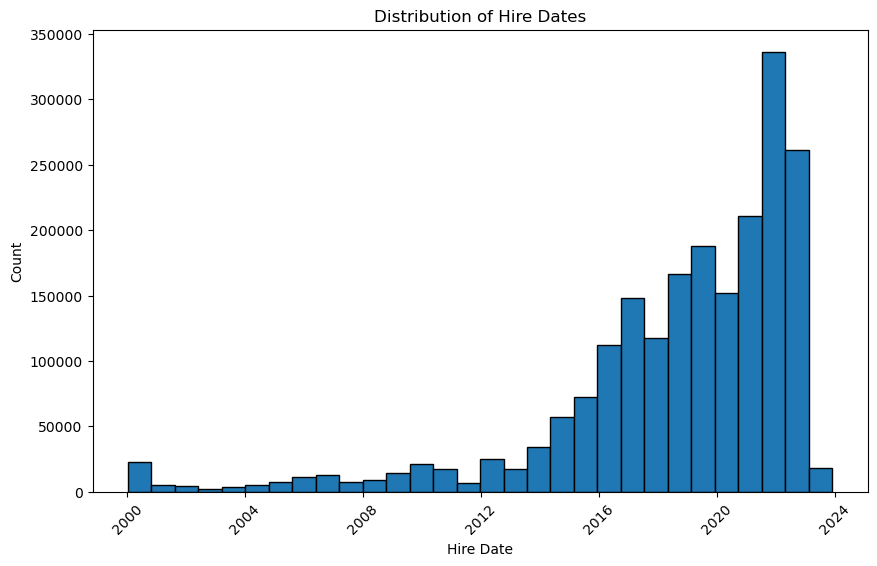

Min Hire Date: 2000-01-07 00:00:00+00:00
Max Hire Date: 2023-12-01 00:00:00+00:00
Mean Hire Date: 2018-08-23 11:55:58.057218816+00:00
Median Hire Date: 2019-09-23 00:00:00+00:00


In [26]:
# Calculate summary statistics
min_hire_date = df['HIREDATE'].min()
max_hire_date = df['HIREDATE'].max()
mean_hire_date = df['HIREDATE'].mean()
median_hire_date = df['HIREDATE'].median()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['HIREDATE'], bins=30, edgecolor='black')
plt.xlabel('Hire Date')
plt.ylabel('Count')
plt.title('Distribution of Hire Dates')
plt.xticks(rotation=45)
plt.show()

# Print summary statistics
print('Min Hire Date:', min_hire_date)
print('Max Hire Date:', max_hire_date)
print('Mean Hire Date:', mean_hire_date)
print('Median Hire Date:', median_hire_date)


## BIRTH_DATE

In [16]:
# Convert 'BANK_TIME' column to datetime
df['BIRTH_DATE'] = pd.to_datetime(df['BIRTH_DATE'])

# Assuming all datetime objects in the 'BANK_TIME' column are in a specific timezone
desired_timezone = pytz.timezone('UTC')

# Localize 'BANK_TIME' column to the desired timezone
df['BIRTH_DATE'] = df['BIRTH_DATE'].dt.tz_localize(desired_timezone)

# Define your current datetime
current_datetime = pd.Timestamp('2023-06-01 18:43:00', tz=desired_timezone)

# Perform operations with the timezone-aware 'current_datetime' and 'df['BANK_TIME']'
df['BIRTH_DATE_Time_diff'] = (current_datetime - df['BIRTH_DATE']).dt.days
df['BIRTH_DATE_Hours'] = df['BIRTH_DATE'].dt.hour
df['BIRTH_DATE_Weekday'] = df['BIRTH_DATE'].dt.weekday + 1
df['BIRTH_DATE_Year'] = df['BIRTH_DATE'].dt.year
df['BIRTH_DATE_Day_of_Year'] = df['BIRTH_DATE'].dt.dayofyear
df['BIRTH_DATE_Month'] = df['BIRTH_DATE'].dt.month

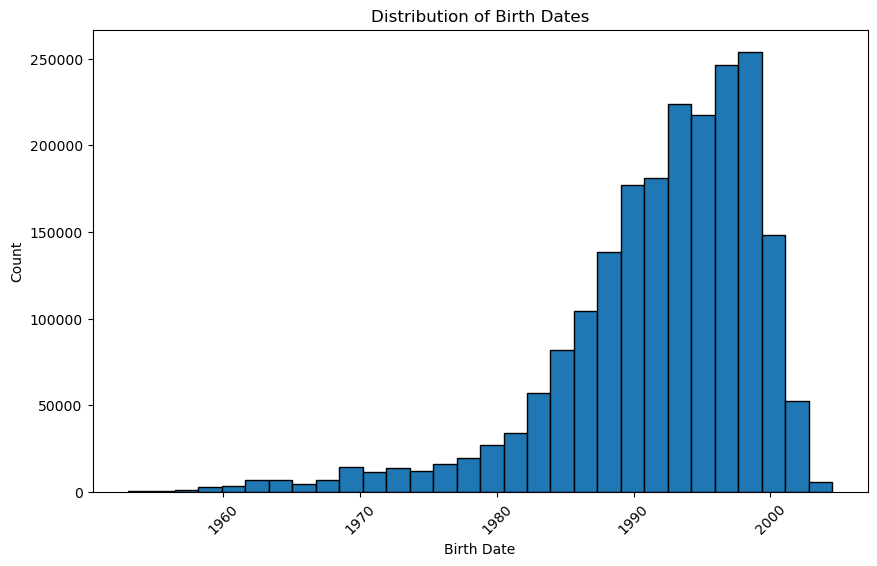

Min Birth Date: 1953-01-10 00:00:00+00:00
Max Birth Date: 2004-07-09 00:00:00+00:00
Mean Birth Date: 1991-11-26 17:29:12.337244544+00:00
Median Birth Date: 1993-05-05 00:00:00+00:00


In [25]:
# Calculate summary statistics
min_birth_date = df['BIRTH_DATE'].min()
max_birth_date = df['BIRTH_DATE'].max()
mean_birth_date = df['BIRTH_DATE'].mean()
median_birth_date = df['BIRTH_DATE'].median()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['BIRTH_DATE'], bins=30, edgecolor='black')
plt.xlabel('Birth Date')
plt.ylabel('Count')
plt.title('Distribution of Birth Dates')
plt.xticks(rotation=45)
plt.show()

# Print summary statistics
print('Min Birth Date:', min_birth_date)
print('Max Birth Date:', max_birth_date)
print('Mean Birth Date:', mean_birth_date)
print('Median Birth Date:', median_birth_date)


## BANK_TIME

In [17]:
# Convert 'BANK_TIME' column to datetime
df['BANK_TIME'] = pd.to_datetime(df['BANK_TIME'])

# Assuming all datetime objects in the 'BANK_TIME' column are in a specific timezone
desired_timezone = pytz.timezone('UTC')

# Localize 'BANK_TIME' column to the desired timezone
df['BANK_TIME'] = df['BANK_TIME'].dt.tz_localize(desired_timezone)

# Define your current datetime
current_datetime = pd.Timestamp('2023-06-01 18:43:00', tz=desired_timezone)

# Perform operations with the timezone-aware 'current_datetime' and 'df['BANK_TIME']'
df['Time_diff'] = (current_datetime - df['BANK_TIME']).dt.days
df['Hours'] = df['BANK_TIME'].dt.hour
df['Weekday'] = df['BANK_TIME'].dt.weekday + 1
df['Year'] = df['BANK_TIME'].dt.year
df['Day_of_Year'] = df['BANK_TIME'].dt.dayofyear
df['Month'] = df['BANK_TIME'].dt.month

In [18]:
df

,BANK_TIME,TERMOWNER,CASHBACK_RATE,CASHBACK_AMOUNT,BALANCE_AFTER,DIRECTION,PIN,MARSTAT,BIRTH_DATE,HIREDATE,...,BIRTH_DATE_Weekday,BIRTH_DATE_Year,BIRTH_DATE_Day_of_Year,BIRTH_DATE_Month,Time_diff,Hours,Weekday,Year,Day_of_Year,Month
76696,2021-09-10 00:06:00+00:00,www.birbank.az/mobil,0.3,0.0,0.0,CREDIT,5BZSUX1,Subay,1992-04-08 00:00:00+00:00,2014-11-11 00:00:00+00:00,...,3,1992,99,4,629,0,5,2021,253,9
1576710,2021-09-10 00:12:04+00:00,www.birbank.az/internet,0.5,0.1,0.1,CREDIT,27HU8E8,Evli,1986-04-30 00:00:00+00:00,2015-01-15 00:00:00+00:00,...,3,1986,120,4,629,0,5,2021,253,9
508179,2021-09-10 00:12:04+00:00,www.birbank.az/mobil,0.5,0.0,0.0,CREDIT,5B6KSE3,Subay,1992-01-25 00:00:00+00:00,2014-01-07 00:00:00+00:00,...,6,1992,25,1,629,0,5,2021,253,9
504996,2021-09-10 00:12:04+00:00,www.birbank.az/mobil,0.5,0.0,0.0,CREDIT,2785F6X,Subay,1986-03-12 00:00:00+00:00,2015-09-17 00:00:00+00:00,...,3,1986,71,3,629,0,5,2021,253,9
1718900,2021-09-10 00:16:04+00:00,www.birbank.az/mobil,0.5,0.0,0.0,CREDIT,4SP0AQ5,Subay,1990-06-03 00:00:00+00:00,2018-11-09 00:00:00+00:00,...,7,1990,154,6,629,0,5,2021,253,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276923,2023-05-31 02:52:35+00:00,www.birbank.az,0.0,0.0,0.0,CREDIT,70JJ5LN,Subay,1999-12-27 00:00:00+00:00,2021-08-12 00:00:00+00:00,...,1,1999,361,12,1,2,3,2023,151,5
1768689,2023-05-31 02:56:15+00:00,www.birbank.az/mobil,1.0,0.0,1.8,CREDIT,5G4GHC0,Evli,1992-07-23 00:00:00+00:00,2015-02-17 00:00:00+00:00,...,4,1992,205,7,1,2,3,2023,151,5
1835227,2023-05-31 03:33:51+00:00,www.birbank.az/creditpay,0.0,0.0,34.6,CREDIT,55FXY6L,Evli,1991-11-12 00:00:00+00:00,2015-11-23 00:00:00+00:00,...,2,1991,316,11,1,3,3,2023,151,5
1794771,2023-05-31 03:44:52+00:00,www.birbank.az/mobil,1.0,0.0,0.0,CREDIT,62CXFQA,Subay,1995-11-19 00:00:00+00:00,2019-09-24 00:00:00+00:00,...,7,1995,323,11,1,3,3,2023,151,5


In [29]:
df = df.apply(lambda x: x.str.upper() if x.dtype == "object" else x)

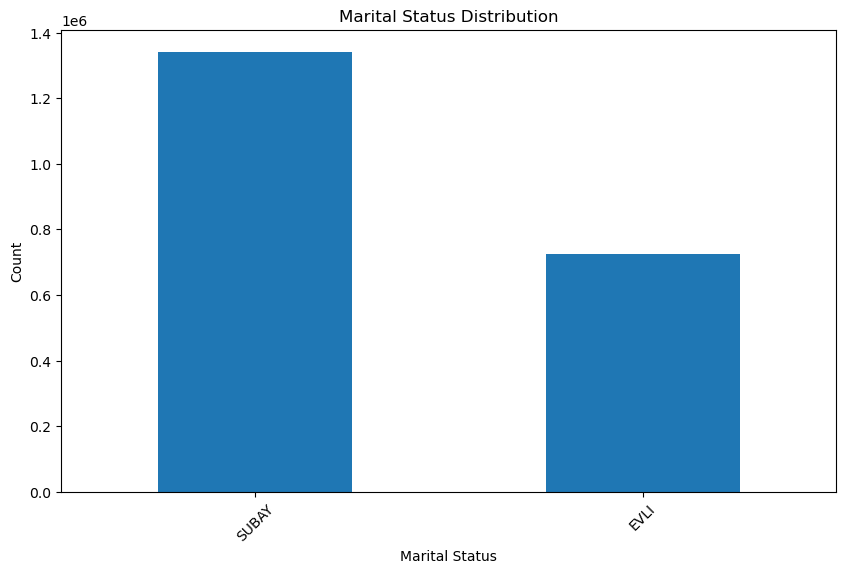

Marital Status Frequencies:
SUBAY    1341638
EVLI      726203
Name: MARSTAT, dtype: int64
Cashback Amount Summary Statistics:
count    2.067841e+06
mean     3.178639e-01
std      2.422149e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e-01
75%      2.000000e-01
max      5.000000e+02
Name: CASHBACK_AMOUNT, dtype: float64


In [35]:
# Marital Status Distribution
marstat_counts = df['MARSTAT'].value_counts()

plt.figure(figsize=(10, 6))
marstat_counts.plot(kind='bar')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Marital Status Distribution')
plt.xticks(rotation=45)
plt.show()

print('Marital Status Frequencies:')
print(marstat_counts)

print('Cashback Amount Summary Statistics:')
print(df['CASHBACK_AMOUNT'].describe())

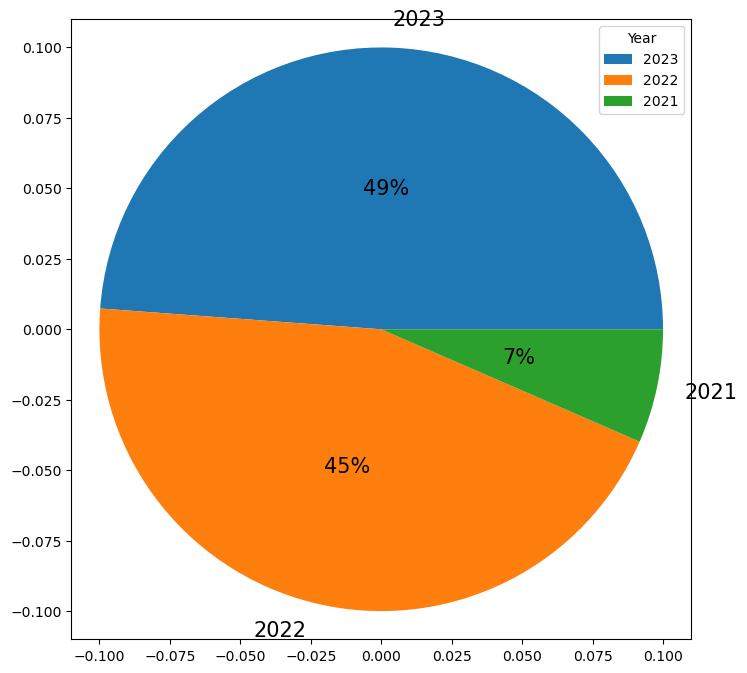

In [32]:
df_year=pd.DataFrame(df.groupby(['Year'])['CASHBACK_AMOUNT'].sum()).sort_values(['CASHBACK_AMOUNT'],ascending=False)
plt.figure(figsize=(8,9))

plt.pie(df_year.CASHBACK_AMOUNT,labels=df_year.index,shadow=False,frame=True,radius=.1, pctdistance = 0.5, autopct = "%0.0f%%",textprops={"fontsize":15} )

plt.legend(title = "Year", loc="upper right")
plt.show()

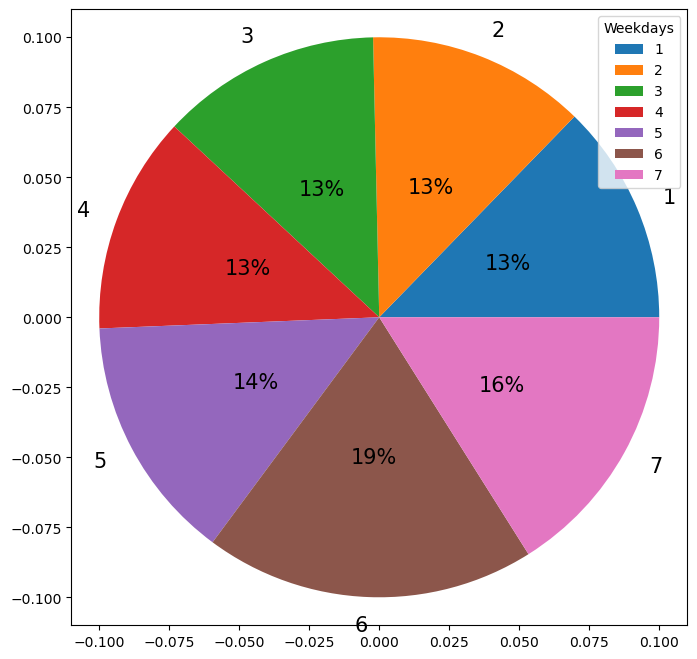

In [20]:
df_weekday=pd.DataFrame(df.groupby(['Weekday'])['CASHBACK_AMOUNT'].sum()).sort_values(['Weekday'],ascending=True)  ## sum
plt.figure(figsize=(8,8))

plt.pie(df_weekday.CASHBACK_AMOUNT,labels=df_weekday.index,shadow=False,frame=True,radius=.1, pctdistance = 0.5, autopct = "%0.0f%%",textprops={"fontsize":15} )

plt.legend(title = "Weekdays", loc="upper right")
plt.show()

<Axes: >

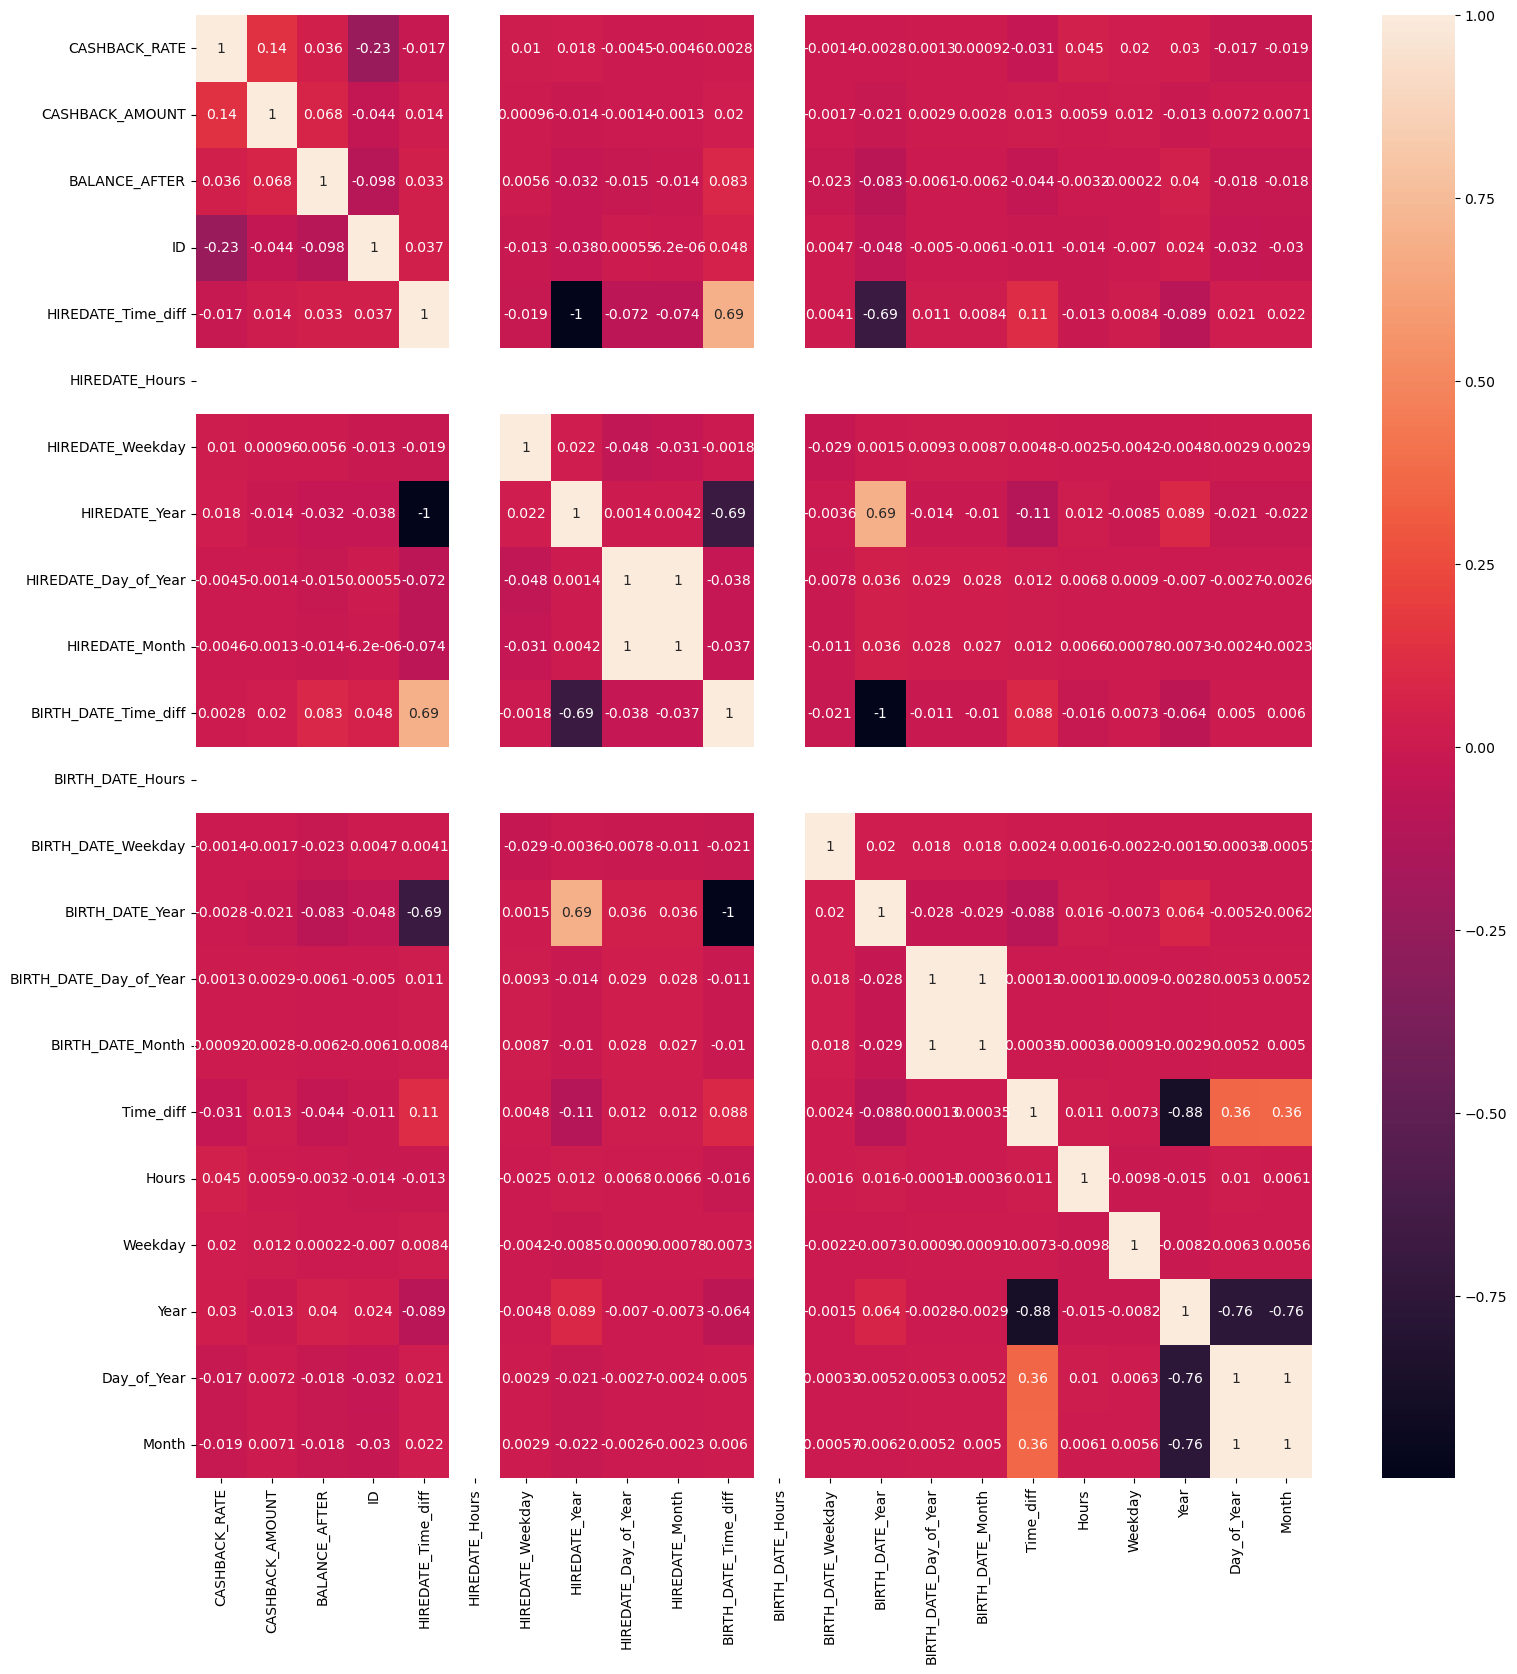

In [24]:
plt.figure(figsize=(18,19))
sns.heatmap(df.corr(),annot=True)